### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


In [4]:
States_track = collections.defaultdict(dict)
Q_dict = collections.defaultdict(dict)

In [5]:
def Q_state(state):
    return '-'.join(str(e) for e in state)

In [6]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [([1,2,3],(1,3)),([3,5,6],(4,2)),([4,10,2],(3,4)), ([2,7,0],(0,4))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = Q_state(q_values[0])
        action = q_values[1]
        States_track[state][action] = [] 

In [7]:
def save_tracking_states_old():
    """Saves the states to dictionary"""
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [8]:
initialise_tracking_states()

In [9]:
print(States_track)

defaultdict(<class 'dict'>, {'1-2-3': {(1, 3): []}, '3-5-6': {(4, 2): []}, '4-10-2': {(3, 4): []}, '2-7-0': {(0, 4): []}})


In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Tracking the state-action pairs for checking convergence


In [11]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [12]:
num_track = 0
num_train = 0
num_track_train = 0

In [13]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.06 # 0.06 after fix gave nothing
        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay = -0.003 #for 1k
        self.epsilon_decay = -0.0007 #for 3k
        #self.epsilon_decay = -0.0003 #for 10k
        #self.epsilon_decay = -0.0001 #for 20k
        #self.epsilon_decay = -0.00003 #for 100k
        #self.epsilon_decay = -0.000003 #for 1M
        self.epsilon_min = 0.01
        
        self.batch_size = 32      # for 24*1
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        self.states_tracked = []
        #track_input = np.zeros((1, self.state_size))
        #track_input[0] = env.state_encod_arch1([0,0,0]).reshape(1,36)
        #self.track_state = track_input[0]
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        #print("TRACK STATE")
        #print(self.track_state)
        self.explore = 0
        self.exploit = 0
        self.num_track = 0
        self.num_train = 0
        self.num_train_track = 0
        self.hit = False
        self.hit_index = 0

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
        action_indices, action_list = env.requests(state)
        if np.random.rand() <= self.epsilon:
            self.explore += 1
            action_list_index = random.randrange(len(action_indices))
            action_space_index = action_indices[action_list_index]
        else:
            self.exploit += 1
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
            q_value =[q_value[0][i] for i in action_indices]
            action_list_index = np.argmax(q_value)
            action_space_index = action_indices[action_list_index]
        return action_space_index, action_list[action_list_index]
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment

    def append_sample(self, state, action_index, reward, next_state, done):
        self.memory.append((state, action_index, reward, next_state, done))
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            self.num_train += 1
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        self.num_track += 1
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [14]:
Episodes = 1

### DQN block

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent
    
    
    while !terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

In [15]:
state_size = 36
action_size = 21
episode_time = 24*30
#n_episodes = 1
n_episodes = 3000
m = 5
t = 24
d = 7
num_track = 0
num_train = 0
num_track_train = 0
env = CabDriver()
agent = DQNAgent(action_size=action_size, state_size=state_size)


# to store rewards in each episode
rewards_per_episode, episodes = [], []

In [16]:
start_time = time.time()
score_tracked = []
num_hits = 0
num_track = 0
num_train = 0
num_track_train = 0
for episode in range(n_episodes):

    done = False
    score = 0

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    state_size = m+t+d
    action_size = len(action_space)
    #agent = DQNAgent(state_size, action_size)
    #print(state)
    #print(state_space)
    total_time = 0
    step_num = 0
    while not done:
        step_num = step_num + 1
        #print(step_num)
        # get action for the current state and take a step in the environment
        action_index, action = agent.get_action(state)
        if ((state_space.index(state) == 0) and (action_index == 2)):
            num_hits = num_hits + 1
        #print(state, action)
        reward, next_state, step_time = env.step(state, action, Time_matrix)
        #print(state, next_state, reward)
        total_time += step_time
        if (total_time > episode_time):
            done = True
            #reward = 0
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state, action_index, reward, next_state, done)

        # train after each step
        agent.train_model()

        # add reward to the total score of this episode
        score += reward
        state = next_state


    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    #agent.epsilon = agent.epsilon * 0.999 # for 2k
    #(1 - 0.0001) * np.exp(-0.003*i)
    #if agent.epsilon > agent.epsilon_min:
    #    agent.epsilon *= agent.epsilon_decay

    # every episode:
    if (episode % 1 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4} step_num {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time, step_num))
        agent.save_tracking_states()
        score_tracked.append(score) 

elapsed_time = time.time() - start_time
#save_obj(States_track,'States_tracked')   
print(elapsed_time)
    # every few episodes:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        #agent.save_model_weights(name="model_weights.h5")


episode 0, reward 129.0, memory_length 137, epsilon 0.99999 total_time 723.0 step_num 137
episode 1, reward -185.0, memory_length 277, epsilon 0.9992902519403939 total_time 730.0 step_num 140
episode 2, reward -49.0, memory_length 428, epsilon 0.9985909935330313 total_time 728.0 step_num 151
episode 3, reward -331.0, memory_length 564, epsilon 0.9978922244352755 total_time 725.0 step_num 136
episode 4, reward -86.0, memory_length 700, epsilon 0.9971939443047295 total_time 721.0 step_num 136
episode 5, reward 110.0, memory_length 847, epsilon 0.9964961527992363 total_time 725.0 step_num 147
episode 6, reward -313.0, memory_length 978, epsilon 0.9957988495768779 total_time 725.0 step_num 131
episode 7, reward -320.0, memory_length 1120, epsilon 0.9951020342959757 total_time 721.0 step_num 142
episode 8, reward -286.0, memory_length 1254, epsilon 0.9944057066150902 total_time 725.0 step_num 134
episode 9, reward -172.0, memory_length 1389, epsilon 0.9937098661930208 total_time 722.0 step_

episode 80, reward -229.0, memory_length 2000, epsilon 0.9455296804990374 total_time 728.0 step_num 133
episode 81, reward -54.0, memory_length 2000, epsilon 0.9448680413234165 total_time 729.0 step_num 114
episode 82, reward -186.0, memory_length 2000, epsilon 0.9442068651331547 total_time 723.0 step_num 127
episode 83, reward -365.0, memory_length 2000, epsilon 0.9435461516042758 total_time 721.0 step_num 140
episode 84, reward -118.0, memory_length 2000, epsilon 0.94288590041303 total_time 722.0 step_num 145
episode 85, reward -99.0, memory_length 2000, epsilon 0.9422261112358943 total_time 738.0 step_num 170
episode 86, reward 238.0, memory_length 2000, epsilon 0.9415667837495718 total_time 721.0 step_num 121
episode 87, reward -231.0, memory_length 2000, epsilon 0.9409079176309924 total_time 732.0 step_num 151
episode 88, reward -23.0, memory_length 2000, epsilon 0.9402495125573114 total_time 721.0 step_num 136
episode 89, reward -345.0, memory_length 2000, epsilon 0.9395915682059

episode 159, reward -484.0, memory_length 2000, epsilon 0.8946613608694933 total_time 725.0 step_num 136
episode 160, reward 94.0, memory_length 2000, epsilon 0.8940353170577823 total_time 730.0 step_num 148
episode 161, reward -64.0, memory_length 2000, epsilon 0.8934097113233944 total_time 722.0 step_num 129
episode 162, reward 97.0, memory_length 2000, epsilon 0.8927845433597831 total_time 724.0 step_num 150
episode 163, reward 82.0, memory_length 2000, epsilon 0.8921598128606157 total_time 736.0 step_num 130
episode 164, reward -93.0, memory_length 2000, epsilon 0.8915355195197746 total_time 726.0 step_num 126
episode 165, reward -239.0, memory_length 2000, epsilon 0.8909116630313557 total_time 721.0 step_num 122
episode 166, reward -108.0, memory_length 2000, epsilon 0.8902882430896697 total_time 729.0 step_num 135
episode 167, reward 197.0, memory_length 2000, epsilon 0.8896652593892407 total_time 722.0 step_num 121
episode 168, reward 221.0, memory_length 2000, epsilon 0.8890427

episode 238, reward 121.0, memory_length 2000, epsilon 0.8465296935051303 total_time 721.0 step_num 136
episode 239, reward 131.0, memory_length 2000, epsilon 0.8459373300710668 total_time 728.0 step_num 119
episode 240, reward -142.0, memory_length 2000, epsilon 0.845345381146312 total_time 734.0 step_num 132
episode 241, reward 17.0, memory_length 2000, epsilon 0.8447538464408108 total_time 731.0 step_num 133
episode 242, reward -13.0, memory_length 2000, epsilon 0.8441627256647113 total_time 737.0 step_num 131
episode 243, reward 173.0, memory_length 2000, epsilon 0.8435720185283643 total_time 725.0 step_num 122
episode 244, reward -266.0, memory_length 2000, epsilon 0.8429817247423231 total_time 721.0 step_num 131
episode 245, reward -415.0, memory_length 2000, epsilon 0.842391844017344 total_time 722.0 step_num 144
episode 246, reward -312.0, memory_length 2000, epsilon 0.8418023760643853 total_time 723.0 step_num 130
episode 247, reward -23.0, memory_length 2000, epsilon 0.841213

episode 317, reward 166.0, memory_length 2000, epsilon 0.8009874499212043 total_time 730.0 step_num 146
episode 318, reward -275.0, memory_length 2000, epsilon 0.8004269549024029 total_time 721.0 step_num 125
episode 319, reward -122.0, memory_length 2000, epsilon 0.7998668520928254 total_time 721.0 step_num 108
episode 320, reward -356.0, memory_length 2000, epsilon 0.7993071412180214 total_time 721.0 step_num 119
episode 321, reward -85.0, memory_length 2000, epsilon 0.7987478220037326 total_time 728.0 step_num 133
episode 322, reward -3.0, memory_length 2000, epsilon 0.7981888941758928 total_time 726.0 step_num 123
episode 323, reward 74.0, memory_length 2000, epsilon 0.7976303574606269 total_time 725.0 step_num 124
episode 324, reward -233.0, memory_length 2000, epsilon 0.7970722115842521 total_time 727.0 step_num 127
episode 325, reward 3.0, memory_length 2000, epsilon 0.7965144562732769 total_time 723.0 step_num 135
episode 326, reward -177.0, memory_length 2000, epsilon 0.795957

episode 396, reward -10.0, memory_length 2000, epsilon 0.7578953223421517 total_time 722.0 step_num 135
episode 397, reward 66.0, memory_length 2000, epsilon 0.7573649812575475 total_time 723.0 step_num 145
episode 398, reward 242.0, memory_length 2000, epsilon 0.7568350112817991 total_time 722.0 step_num 131
episode 399, reward -6.0, memory_length 2000, epsilon 0.7563054121552215 total_time 732.0 step_num 137
episode 400, reward -109.0, memory_length 2000, epsilon 0.7557761836183109 total_time 722.0 step_num 129
episode 401, reward -20.0, memory_length 2000, epsilon 0.7552473254117454 total_time 733.0 step_num 127
episode 402, reward 94.0, memory_length 2000, epsilon 0.7547188372763846 total_time 721.0 step_num 123
episode 403, reward -127.0, memory_length 2000, epsilon 0.754190718953269 total_time 731.0 step_num 109
episode 404, reward 17.0, memory_length 2000, epsilon 0.7536629701836209 total_time 722.0 step_num 115
episode 405, reward -69.0, memory_length 2000, epsilon 0.7531355907

episode 475, reward 155.0, memory_length 2000, epsilon 0.717121497577297 total_time 725.0 step_num 124
episode 476, reward -235.0, memory_length 2000, epsilon 0.7166196881827716 total_time 731.0 step_num 111
episode 477, reward -5.0, memory_length 2000, epsilon 0.7161182299319077 total_time 730.0 step_num 134
episode 478, reward -88.0, memory_length 2000, epsilon 0.7156171225789908 total_time 725.0 step_num 132
episode 479, reward -14.0, memory_length 2000, epsilon 0.7151163658784782 total_time 730.0 step_num 140
episode 480, reward -405.0, memory_length 2000, epsilon 0.7146159595849991 total_time 729.0 step_num 136
episode 481, reward -115.0, memory_length 2000, epsilon 0.7141159034533547 total_time 725.0 step_num 129
episode 482, reward 292.0, memory_length 2000, epsilon 0.7136161972385172 total_time 721.0 step_num 137
episode 483, reward 129.0, memory_length 2000, epsilon 0.7131168406956307 total_time 723.0 step_num 131
episode 484, reward 125.0, memory_length 2000, epsilon 0.712617

episode 554, reward -51.0, memory_length 2000, epsilon 0.6785412538215153 total_time 723.0 step_num 117
episode 555, reward -277.0, memory_length 2000, epsilon 0.6780664411476643 total_time 725.0 step_num 113
episode 556, reward 272.0, memory_length 2000, epsilon 0.6775919607263831 total_time 725.0 step_num 136
episode 557, reward 279.0, memory_length 2000, epsilon 0.6771178123251761 total_time 729.0 step_num 134
episode 558, reward 139.0, memory_length 2000, epsilon 0.6766439957117106 total_time 721.0 step_num 111
episode 559, reward 125.0, memory_length 2000, epsilon 0.6761705106538167 total_time 722.0 step_num 131
episode 560, reward 172.0, memory_length 2000, epsilon 0.6756973569194864 total_time 727.0 step_num 122
episode 561, reward 255.0, memory_length 2000, epsilon 0.6752245342768747 total_time 723.0 step_num 113
episode 562, reward -12.0, memory_length 2000, epsilon 0.6747520424942982 total_time 726.0 step_num 140
episode 563, reward -124.0, memory_length 2000, epsilon 0.67427

episode 633, reward 29.0, memory_length 2000, epsilon 0.6420365791475197 total_time 725.0 step_num 142
episode 634, reward -112.0, memory_length 2000, epsilon 0.6415873108043817 total_time 728.0 step_num 126
episode 635, reward 279.0, memory_length 2000, epsilon 0.6411383568390387 total_time 729.0 step_num 123
episode 636, reward 526.0, memory_length 2000, epsilon 0.6406897170315036 total_time 721.0 step_num 125
episode 637, reward 129.0, memory_length 2000, epsilon 0.6402413911619425 total_time 732.0 step_num 125
episode 638, reward 187.0, memory_length 2000, epsilon 0.6397933790106759 total_time 733.0 step_num 132
episode 639, reward 188.0, memory_length 2000, epsilon 0.6393456803581778 total_time 722.0 step_num 128
episode 640, reward 251.0, memory_length 2000, epsilon 0.638898294985076 total_time 722.0 step_num 139
episode 641, reward 102.0, memory_length 2000, epsilon 0.6384512226721513 total_time 723.0 step_num 118
episode 642, reward -100.0, memory_length 2000, epsilon 0.6380044

episode 712, reward 8.0, memory_length 2000, epsilon 0.6074958105227866 total_time 722.0 step_num 126
episode 713, reward 17.0, memory_length 2000, epsilon 0.6070707122571718 total_time 722.0 step_num 127
episode 714, reward -203.0, memory_length 2000, epsilon 0.6066459114562182 total_time 721.0 step_num 135
episode 715, reward 150.0, memory_length 2000, epsilon 0.6062214079117734 total_time 726.0 step_num 128
episode 716, reward 208.0, memory_length 2000, epsilon 0.6057972014158304 total_time 727.0 step_num 132
episode 717, reward -220.0, memory_length 2000, epsilon 0.6053732917605282 total_time 728.0 step_num 134
episode 718, reward -28.0, memory_length 2000, epsilon 0.6049496787381513 total_time 722.0 step_num 129
episode 719, reward -32.0, memory_length 2000, epsilon 0.604526362141129 total_time 721.0 step_num 126
episode 720, reward -10.0, memory_length 2000, epsilon 0.6041033417620362 total_time 722.0 step_num 110
episode 721, reward -90.0, memory_length 2000, epsilon 0.603680617

episode 791, reward 375.0, memory_length 2000, epsilon 0.5748132922469222 total_time 726.0 step_num 127
episode 792, reward -42.0, memory_length 2000, epsilon 0.5744110637387515 total_time 723.0 step_num 118
episode 793, reward 499.0, memory_length 2000, epsilon 0.5740091166920136 total_time 721.0 step_num 124
episode 794, reward -66.0, memory_length 2000, epsilon 0.5736074509097544 total_time 726.0 step_num 110
episode 795, reward 262.0, memory_length 2000, epsilon 0.5732060661951575 total_time 727.0 step_num 115
episode 796, reward 168.0, memory_length 2000, epsilon 0.5728049623515445 total_time 726.0 step_num 124
episode 797, reward -1.0, memory_length 2000, epsilon 0.5724041391823748 total_time 731.0 step_num 127
episode 798, reward 235.0, memory_length 2000, epsilon 0.5720035964912444 total_time 727.0 step_num 118
episode 799, reward -260.0, memory_length 2000, epsilon 0.5716033340818878 total_time 727.0 step_num 125
episode 800, reward -16.0, memory_length 2000, epsilon 0.5712033

episode 870, reward -43.0, memory_length 2000, epsilon 0.5438890527646728 total_time 725.0 step_num 119
episode 871, reward 178.0, memory_length 2000, epsilon 0.5435084636494686 total_time 724.0 step_num 125
episode 872, reward 239.0, memory_length 2000, epsilon 0.5431281408534225 total_time 728.0 step_num 134
episode 873, reward 175.0, memory_length 2000, epsilon 0.5427480841901762 total_time 721.0 step_num 122
episode 874, reward 337.0, memory_length 2000, epsilon 0.542368293473502 total_time 730.0 step_num 118
episode 875, reward 340.0, memory_length 2000, epsilon 0.5419887685173026 total_time 724.0 step_num 142
episode 876, reward -5.0, memory_length 2000, epsilon 0.5416095091356105 total_time 721.0 step_num 120
episode 877, reward 359.0, memory_length 2000, epsilon 0.5412305151425887 total_time 722.0 step_num 119
episode 878, reward 89.0, memory_length 2000, epsilon 0.5408517863525302 total_time 722.0 step_num 133
episode 879, reward 8.0, memory_length 2000, epsilon 0.540473322579

episode 950, reward 157.0, memory_length 2000, epsilon 0.5142683849713549 total_time 721.0 step_num 125
episode 951, reward 103.0, memory_length 2000, epsilon 0.5139085230682354 total_time 721.0 step_num 127
episode 952, reward 185.0, memory_length 2000, epsilon 0.5135489129803025 total_time 728.0 step_num 129
episode 953, reward 220.0, memory_length 2000, epsilon 0.5131895545313472 total_time 721.0 step_num 120
episode 954, reward 350.0, memory_length 2000, epsilon 0.5128304475452841 total_time 722.0 step_num 120
episode 955, reward 155.0, memory_length 2000, epsilon 0.5124715918461503 total_time 725.0 step_num 118
episode 956, reward 217.0, memory_length 2000, epsilon 0.5121129872581067 total_time 736.0 step_num 104
episode 957, reward 202.0, memory_length 2000, epsilon 0.5117546336054374 total_time 721.0 step_num 120
episode 958, reward 164.0, memory_length 2000, epsilon 0.5113965307125485 total_time 725.0 step_num 117
episode 959, reward 140.0, memory_length 2000, epsilon 0.5110386

episode 1029, reward -60.0, memory_length 2000, epsilon 0.4866013861223232 total_time 723.0 step_num 113
episode 1030, reward 13.0, memory_length 2000, epsilon 0.4862608843415646 total_time 730.0 step_num 128
episode 1031, reward -9.0, memory_length 2000, epsilon 0.4859206208286491 total_time 729.0 step_num 105
episode 1032, reward 252.0, memory_length 2000, epsilon 0.4855805954168475 total_time 729.0 step_num 124
episode 1033, reward -19.0, memory_length 2000, epsilon 0.4852408079395475 total_time 731.0 step_num 127
episode 1034, reward 319.0, memory_length 2000, epsilon 0.484901258230253 total_time 721.0 step_num 111
episode 1035, reward 188.0, memory_length 2000, epsilon 0.48456194612258474 total_time 722.0 step_num 123
episode 1036, reward 157.0, memory_length 2000, epsilon 0.4842228714502798 total_time 721.0 step_num 129
episode 1037, reward 93.0, memory_length 2000, epsilon 0.48388403404719155 total_time 723.0 step_num 129
episode 1038, reward 64.0, memory_length 2000, epsilon 0.

episode 1107, reward 274.0, memory_length 2000, epsilon 0.4607452461821246 total_time 730.0 step_num 135
episode 1108, reward -5.0, memory_length 2000, epsilon 0.4604228373660478 total_time 721.0 step_num 119
episode 1109, reward 102.0, memory_length 2000, epsilon 0.4601006541571705 total_time 723.0 step_num 129
episode 1110, reward 103.0, memory_length 2000, epsilon 0.4597786963976229 total_time 721.0 step_num 127
episode 1111, reward 167.0, memory_length 2000, epsilon 0.4594569639296458 total_time 728.0 step_num 121
episode 1112, reward 230.0, memory_length 2000, epsilon 0.4591354565955902 total_time 737.0 step_num 122
episode 1113, reward -7.0, memory_length 2000, epsilon 0.4588141742379175 total_time 725.0 step_num 110
episode 1114, reward 155.0, memory_length 2000, epsilon 0.45849311669919934 total_time 734.0 step_num 119
episode 1115, reward 239.0, memory_length 2000, epsilon 0.45817228382211755 total_time 728.0 step_num 121
episode 1116, reward -145.0, memory_length 2000, epsilo

episode 1185, reward 140.0, memory_length 2000, epsilon 0.4362630028062879 total_time 728.0 step_num 109
episode 1186, reward 219.0, memory_length 2000, epsilon 0.43595772556382384 total_time 723.0 step_num 116
episode 1187, reward 147.0, memory_length 2000, epsilon 0.435652661940654 total_time 723.0 step_num 113
episode 1188, reward 38.0, memory_length 2000, epsilon 0.43534781178729726 total_time 725.0 step_num 128
episode 1189, reward 248.0, memory_length 2000, epsilon 0.435043174954377 total_time 728.0 step_num 125
episode 1190, reward 26.0, memory_length 2000, epsilon 0.43473875129262124 total_time 722.0 step_num 121
episode 1191, reward -28.0, memory_length 2000, epsilon 0.43443454065286224 total_time 722.0 step_num 115
episode 1192, reward 273.0, memory_length 2000, epsilon 0.43413054288603686 total_time 723.0 step_num 121
episode 1193, reward -5.0, memory_length 2000, epsilon 0.4338267578431862 total_time 721.0 step_num 121
episode 1194, reward 346.0, memory_length 2000, epsilon

episode 1263, reward 250.0, memory_length 2000, epsilon 0.4130816523765647 total_time 724.0 step_num 110
episode 1264, reward -68.0, memory_length 2000, epsilon 0.4127925964012956 total_time 730.0 step_num 106
episode 1265, reward 422.0, memory_length 2000, epsilon 0.412503742694407 total_time 722.0 step_num 118
episode 1266, reward -95.0, memory_length 2000, epsilon 0.4122150911143605 total_time 721.0 step_num 126
episode 1267, reward -95.0, memory_length 2000, epsilon 0.4119266415197169 total_time 730.0 step_num 114
episode 1268, reward -5.0, memory_length 2000, epsilon 0.41163839376913597 total_time 721.0 step_num 110
episode 1269, reward 269.0, memory_length 2000, epsilon 0.41135034772137613 total_time 722.0 step_num 126
episode 1270, reward 166.0, memory_length 2000, epsilon 0.411062503235295 total_time 730.0 step_num 104
episode 1271, reward 149.0, memory_length 2000, epsilon 0.41077486016984854 total_time 728.0 step_num 128
episode 1272, reward 140.0, memory_length 2000, epsilon

episode 1341, reward 75.0, memory_length 2000, epsilon 0.3911320704082718 total_time 723.0 step_num 119
episode 1342, reward 503.0, memory_length 2000, epsilon 0.39085837376398747 total_time 722.0 step_num 128
episode 1343, reward 173.0, memory_length 2000, epsilon 0.3905848686403141 total_time 725.0 step_num 111
episode 1344, reward 177.0, memory_length 2000, epsilon 0.39031155490323416 total_time 726.0 step_num 117
episode 1345, reward 355.0, memory_length 2000, epsilon 0.3900384324188239 total_time 721.0 step_num 107
episode 1346, reward 301.0, memory_length 2000, epsilon 0.38976550105325336 total_time 721.0 step_num 118
episode 1347, reward 389.0, memory_length 2000, epsilon 0.38949276067278615 total_time 725.0 step_num 128
episode 1348, reward 134.0, memory_length 2000, epsilon 0.38922021114377947 total_time 722.0 step_num 123
episode 1349, reward 197.0, memory_length 2000, epsilon 0.38894785233268403 total_time 722.0 step_num 134
episode 1350, reward 103.0, memory_length 2000, ep

episode 1419, reward 323.0, memory_length 2000, epsilon 0.37034880542794235 total_time 722.0 step_num 114
episode 1420, reward 238.0, memory_length 2000, epsilon 0.37008965197843224 total_time 721.0 step_num 111
episode 1421, reward 230.0, memory_length 2000, epsilon 0.3698306798728589 total_time 728.0 step_num 115
episode 1422, reward 203.0, memory_length 2000, epsilon 0.3695718889843262 total_time 728.0 step_num 104
episode 1423, reward 13.0, memory_length 2000, epsilon 0.3693132791860265 total_time 721.0 step_num 105
episode 1424, reward 146.0, memory_length 2000, epsilon 0.36905485035124097 total_time 725.0 step_num 122
episode 1425, reward 485.0, memory_length 2000, epsilon 0.3687966023533395 total_time 722.0 step_num 125
episode 1426, reward 50.0, memory_length 2000, epsilon 0.36853853506578055 total_time 728.0 step_num 114
episode 1427, reward 307.0, memory_length 2000, epsilon 0.36828064836211116 total_time 727.0 step_num 119
episode 1428, reward 299.0, memory_length 2000, epsi

episode 1497, reward 417.0, memory_length 2000, epsilon 0.3506698838035328 total_time 723.0 step_num 118
episode 1498, reward -48.0, memory_length 2000, epsilon 0.35042450077894877 total_time 735.0 step_num 132
episode 1499, reward 361.0, memory_length 2000, epsilon 0.35017928946237714 total_time 727.0 step_num 122
episode 1500, reward 264.0, memory_length 2000, epsilon 0.3499342497336642 total_time 723.0 step_num 125
episode 1501, reward 571.0, memory_length 2000, epsilon 0.3496893814727408 total_time 721.0 step_num 121
episode 1502, reward 257.0, memory_length 2000, epsilon 0.3494446845596213 total_time 728.0 step_num 134
episode 1503, reward 291.0, memory_length 2000, epsilon 0.3492001588744042 total_time 723.0 step_num 122
episode 1504, reward 323.0, memory_length 2000, epsilon 0.3489558042972719 total_time 722.0 step_num 106
episode 1505, reward -65.0, memory_length 2000, epsilon 0.34871162070849077 total_time 724.0 step_num 109
episode 1506, reward 152.0, memory_length 2000, epsi

episode 1575, reward 220.0, memory_length 2000, epsilon 0.3320366249452072 total_time 730.0 step_num 119
episode 1576, reward -103.0, memory_length 2000, epsilon 0.3318042806377406 total_time 728.0 step_num 117
episode 1577, reward 243.0, memory_length 2000, epsilon 0.3315720989143781 total_time 729.0 step_num 108
episode 1578, reward 219.0, memory_length 2000, epsilon 0.33134007966135065 total_time 723.0 step_num 106
episode 1579, reward 80.0, memory_length 2000, epsilon 0.331108222764969 total_time 722.0 step_num 124
episode 1580, reward 67.0, memory_length 2000, epsilon 0.330876528111623 total_time 721.0 step_num 111
episode 1581, reward 418.0, memory_length 2000, epsilon 0.33064499558778243 total_time 721.0 step_num 109
episode 1582, reward 186.0, memory_length 2000, epsilon 0.33041362507999644 total_time 726.0 step_num 121
episode 1583, reward 203.0, memory_length 2000, epsilon 0.3301824164748932 total_time 728.0 step_num 115
episode 1584, reward 203.0, memory_length 2000, epsilon

episode 1653, reward -20.0, memory_length 2000, epsilon 0.314393466325646 total_time 724.0 step_num 114
episode 1654, reward 200.0, memory_length 2000, epsilon 0.31417346790764766 total_time 725.0 step_num 128
episode 1655, reward 121.0, memory_length 2000, epsilon 0.3139536234346548 total_time 721.0 step_num 120
episode 1656, reward 380.0, memory_length 2000, epsilon 0.31373393279894374 total_time 725.0 step_num 116
episode 1657, reward 272.0, memory_length 2000, epsilon 0.3135143958928661 total_time 725.0 step_num 114
episode 1658, reward 725.0, memory_length 2000, epsilon 0.31329501260884857 total_time 728.0 step_num 115
episode 1659, reward 286.0, memory_length 2000, epsilon 0.3130757828393936 total_time 733.0 step_num 116
episode 1660, reward -266.0, memory_length 2000, epsilon 0.3128567064770785 total_time 721.0 step_num 116
episode 1661, reward 148.0, memory_length 2000, epsilon 0.3126377834145557 total_time 721.0 step_num 115
episode 1662, reward 42.0, memory_length 2000, epsil

episode 1731, reward 473.0, memory_length 2000, epsilon 0.29768779779810817 total_time 728.0 step_num 124
episode 1732, reward 390.0, memory_length 2000, epsilon 0.29747948925614515 total_time 723.0 step_num 108
episode 1733, reward 319.0, memory_length 2000, epsilon 0.29727132647913773 total_time 730.0 step_num 118
episode 1734, reward 202.0, memory_length 2000, epsilon 0.2970633093650863 total_time 721.0 step_num 108
episode 1735, reward 229.0, memory_length 2000, epsilon 0.2968554378120624 total_time 730.0 step_num 117
episode 1736, reward -59.0, memory_length 2000, epsilon 0.2966477117182089 total_time 730.0 step_num 115
episode 1737, reward 224.0, memory_length 2000, epsilon 0.2964401309817402 total_time 722.0 step_num 107
episode 1738, reward -82.0, memory_length 2000, epsilon 0.29623269550094156 total_time 722.0 step_num 112
episode 1739, reward 49.0, memory_length 2000, epsilon 0.2960254051741696 total_time 721.0 step_num 116
episode 1740, reward 234.0, memory_length 2000, epsi

episode 1809, reward 231.0, memory_length 2000, epsilon 0.28186980471819845 total_time 726.0 step_num 119
episode 1810, reward 382.0, memory_length 2000, epsilon 0.28167256489688713 total_time 730.0 step_num 120
episode 1811, reward 490.0, memory_length 2000, epsilon 0.2814754630951382 total_time 721.0 step_num 113
episode 1812, reward 353.0, memory_length 2000, epsilon 0.2812784992163719 total_time 725.0 step_num 119
episode 1813, reward 219.0, memory_length 2000, epsilon 0.28108167316407584 total_time 723.0 step_num 118
episode 1814, reward 287.0, memory_length 2000, epsilon 0.28088498484180513 total_time 722.0 step_num 113
episode 1815, reward 129.0, memory_length 2000, epsilon 0.28068843415318273 total_time 723.0 step_num 115
episode 1816, reward 492.0, memory_length 2000, epsilon 0.2804920210018987 total_time 726.0 step_num 127
episode 1817, reward 314.0, memory_length 2000, epsilon 0.2802957452917105 total_time 722.0 step_num 114
episode 1818, reward 211.0, memory_length 2000, ep

episode 1887, reward 290.0, memory_length 2000, epsilon 0.2668923194015453 total_time 725.0 step_num 109
episode 1888, reward 272.0, memory_length 2000, epsilon 0.2667055601513278 total_time 725.0 step_num 127
episode 1889, reward 337.0, memory_length 2000, epsilon 0.26651893158684004 total_time 721.0 step_num 108
episode 1890, reward 219.0, memory_length 2000, epsilon 0.2663324336166342 total_time 723.0 step_num 101
episode 1891, reward 139.0, memory_length 2000, epsilon 0.2661460661493261 total_time 739.0 step_num 115
episode 1892, reward 114.0, memory_length 2000, epsilon 0.2659598290935958 total_time 726.0 step_num 120
episode 1893, reward 290.0, memory_length 2000, epsilon 0.265773722358187 total_time 725.0 step_num 119
episode 1894, reward -23.0, memory_length 2000, epsilon 0.2655877458519075 total_time 721.0 step_num 112
episode 1895, reward 138.0, memory_length 2000, epsilon 0.2654018994836288 total_time 723.0 step_num 110
episode 1896, reward 78.0, memory_length 2000, epsilon 

episode 1965, reward 339.0, memory_length 2000, epsilon 0.2527106804744507 total_time 726.0 step_num 120
episode 1966, reward 392.0, memory_length 2000, epsilon 0.2525338448977912 total_time 728.0 step_num 120
episode 1967, reward 94.0, memory_length 2000, epsilon 0.25235713306272073 total_time 721.0 step_num 112
episode 1968, reward 635.0, memory_length 2000, epsilon 0.25218054488265057 total_time 728.0 step_num 119
episode 1969, reward 544.0, memory_length 2000, epsilon 0.25200408027105237 total_time 721.0 step_num 112
episode 1970, reward 561.0, memory_length 2000, epsilon 0.2518277391414586 total_time 723.0 step_num 119
episode 1971, reward 250.0, memory_length 2000, epsilon 0.25165152140746205 total_time 724.0 step_num 124
episode 1972, reward 75.0, memory_length 2000, epsilon 0.251475426982716 total_time 723.0 step_num 111
episode 1973, reward 241.0, memory_length 2000, epsilon 0.2512994557809342 total_time 724.0 step_num 121
episode 1974, reward 283.0, memory_length 2000, epsilo

episode 2043, reward 121.0, memory_length 2000, epsilon 0.23928259969810942 total_time 721.0 step_num 118
episode 2044, reward 229.0, memory_length 2000, epsilon 0.23911516048888107 total_time 721.0 step_num 125
episode 2045, reward 209.0, memory_length 2000, epsilon 0.23894783844608616 total_time 725.0 step_num 123
episode 2046, reward 145.0, memory_length 2000, epsilon 0.23878063348773687 total_time 727.0 step_num 117
episode 2047, reward 31.0, memory_length 2000, epsilon 0.2386135455319027 total_time 721.0 step_num 121
episode 2048, reward 344.0, memory_length 2000, epsilon 0.2384465744967107 total_time 725.0 step_num 109
episode 2049, reward 348.0, memory_length 2000, epsilon 0.23827972030034494 total_time 726.0 step_num 107
episode 2050, reward 348.0, memory_length 2000, epsilon 0.2381129828610469 total_time 726.0 step_num 124
episode 2051, reward 157.0, memory_length 2000, epsilon 0.23794636209711523 total_time 721.0 step_num 114
episode 2052, reward -354.0, memory_length 2000, e

episode 2121, reward 211.0, memory_length 2000, epsilon 0.2265680358692807 total_time 730.0 step_num 100
episode 2122, reward 256.0, memory_length 2000, epsilon 0.22640949374039107 total_time 721.0 step_num 123
episode 2123, reward 113.0, memory_length 2000, epsilon 0.226251062552158 total_time 728.0 step_num 117
episode 2124, reward 83.0, memory_length 2000, epsilon 0.22609274222695006 total_time 725.0 step_num 117
episode 2125, reward 202.0, memory_length 2000, epsilon 0.2259345326871903 total_time 721.0 step_num 118
episode 2126, reward 299.0, memory_length 2000, epsilon 0.22577643385535615 total_time 725.0 step_num 109
episode 2127, reward 597.0, memory_length 2000, epsilon 0.22561844565397904 total_time 723.0 step_num 104
episode 2128, reward 377.0, memory_length 2000, epsilon 0.22546056800564482 total_time 722.0 step_num 107
episode 2129, reward 175.0, memory_length 2000, epsilon 0.22530280083299348 total_time 721.0 step_num 107
episode 2130, reward -41.0, memory_length 2000, eps

episode 2199, reward 366.0, memory_length 2000, epsilon 0.214529075421397 total_time 726.0 step_num 107
episode 2200, reward 418.0, memory_length 2000, epsilon 0.21437895761596368 total_time 721.0 step_num 112
episode 2201, reward -149.0, memory_length 2000, epsilon 0.21422894485622396 total_time 721.0 step_num 111
episode 2202, reward 226.0, memory_length 2000, epsilon 0.21407903706867148 total_time 727.0 step_num 119
episode 2203, reward 75.0, memory_length 2000, epsilon 0.2139292341798514 total_time 723.0 step_num 109
episode 2204, reward 233.0, memory_length 2000, epsilon 0.21377953611636044 total_time 722.0 step_num 121
episode 2205, reward 395.0, memory_length 2000, epsilon 0.2136299428048464 total_time 722.0 step_num 108
episode 2206, reward 319.0, memory_length 2000, epsilon 0.21348045417200862 total_time 721.0 step_num 130
episode 2207, reward 340.0, memory_length 2000, epsilon 0.21333107014459768 total_time 724.0 step_num 113
episode 2208, reward 445.0, memory_length 2000, ep

episode 2277, reward 139.0, memory_length 2000, epsilon 0.20312981937007396 total_time 721.0 step_num 112
episode 2278, reward 74.0, memory_length 2000, epsilon 0.20298767825171046 total_time 734.0 step_num 106
episode 2279, reward 374.0, memory_length 2000, epsilon 0.20284563659731333 total_time 728.0 step_num 103
episode 2280, reward 346.0, memory_length 2000, epsilon 0.20270369433728216 total_time 721.0 step_num 121
episode 2281, reward 274.0, memory_length 2000, epsilon 0.20256185140206537 total_time 730.0 step_num 116
episode 2282, reward 500.0, memory_length 2000, epsilon 0.20242010772215974 total_time 728.0 step_num 122
episode 2283, reward 382.0, memory_length 2000, epsilon 0.20227846322811097 total_time 721.0 step_num 123
episode 2284, reward 267.0, memory_length 2000, epsilon 0.2021369178505132 total_time 726.0 step_num 120
episode 2285, reward 355.0, memory_length 2000, epsilon 0.20199547152000927 total_time 721.0 step_num 118
episode 2286, reward -53.0, memory_length 2000, 

episode 2355, reward 220.0, memory_length 2000, epsilon 0.19233627626590455 total_time 721.0 step_num 109
episode 2356, reward 364.0, memory_length 2000, epsilon 0.19220168798391282 total_time 721.0 step_num 107
episode 2357, reward 110.0, memory_length 2000, epsilon 0.19206719388075205 total_time 725.0 step_num 110
episode 2358, reward 142.0, memory_length 2000, epsilon 0.19193279389052006 total_time 724.0 step_num 116
episode 2359, reward 137.0, memory_length 2000, epsilon 0.191798487947361 total_time 725.0 step_num 121
episode 2360, reward 67.0, memory_length 2000, epsilon 0.19166427598546482 total_time 721.0 step_num 102
episode 2361, reward 337.0, memory_length 2000, epsilon 0.1915301579390677 total_time 739.0 step_num 104
episode 2362, reward 202.0, memory_length 2000, epsilon 0.19139613374245185 total_time 721.0 step_num 115
episode 2363, reward 200.0, memory_length 2000, epsilon 0.19126220332994534 total_time 725.0 step_num 121
episode 2364, reward 397.0, memory_length 2000, ep

episode 2433, reward 271.0, memory_length 2000, epsilon 0.18211626083533247 total_time 727.0 step_num 111
episode 2434, reward 165.0, memory_length 2000, epsilon 0.1819888240608225 total_time 723.0 step_num 111
episode 2435, reward 193.0, memory_length 2000, epsilon 0.18186147646083997 total_time 730.0 step_num 115
episode 2436, reward 168.0, memory_length 2000, epsilon 0.18173421797298447 total_time 726.0 step_num 116
episode 2437, reward 385.0, memory_length 2000, epsilon 0.1816070485348995 total_time 733.0 step_num 119
episode 2438, reward 412.0, memory_length 2000, epsilon 0.18147996808427191 total_time 724.0 step_num 123
episode 2439, reward -28.0, memory_length 2000, epsilon 0.18135297655883229 total_time 722.0 step_num 113
episode 2440, reward 94.0, memory_length 2000, epsilon 0.18122607389635484 total_time 730.0 step_num 111
episode 2441, reward 280.0, memory_length 2000, epsilon 0.18109926003465723 total_time 727.0 step_num 124
episode 2442, reward 130.0, memory_length 2000, e

episode 2511, reward -163.0, memory_length 2000, epsilon 0.17243929800736318 total_time 722.0 step_num 124
episode 2512, reward 292.0, memory_length 2000, epsilon 0.17231863273653 total_time 721.0 step_num 129
episode 2513, reward 202.0, memory_length 2000, epsilon 0.17219805190183032 total_time 721.0 step_num 98
episode 2514, reward 544.0, memory_length 2000, epsilon 0.17207755544417944 total_time 721.0 step_num 115
episode 2515, reward 368.0, memory_length 2000, epsilon 0.17195714330453424 total_time 731.0 step_num 115
episode 2516, reward 379.0, memory_length 2000, epsilon 0.1718368154238927 total_time 727.0 step_num 127
episode 2517, reward 222.0, memory_length 2000, epsilon 0.1717165717432941 total_time 726.0 step_num 110
episode 2518, reward 206.0, memory_length 2000, epsilon 0.17159641220381913 total_time 722.0 step_num 118
episode 2519, reward 137.0, memory_length 2000, epsilon 0.17147633674658957 total_time 725.0 step_num 120
episode 2520, reward 571.0, memory_length 2000, eps

episode 2589, reward 383.0, memory_length 2000, epsilon 0.1632765320399289 total_time 728.0 step_num 119
episode 2590, reward 645.0, memory_length 2000, epsilon 0.16316227846091896 total_time 726.0 step_num 122
episode 2591, reward 334.0, memory_length 2000, epsilon 0.16304810483142873 total_time 727.0 step_num 113
episode 2592, reward 546.0, memory_length 2000, epsilon 0.16293401109551311 total_time 726.0 step_num 111
episode 2593, reward 452.0, memory_length 2000, epsilon 0.16281999719726623 total_time 734.0 step_num 112
episode 2594, reward -69.0, memory_length 2000, epsilon 0.1627060630808212 total_time 723.0 step_num 116
episode 2595, reward 172.0, memory_length 2000, epsilon 0.16259220869035035 total_time 727.0 step_num 111
episode 2596, reward 260.0, memory_length 2000, epsilon 0.162478433970065 total_time 722.0 step_num 110
episode 2597, reward 376.0, memory_length 2000, epsilon 0.16236473886421554 total_time 724.0 step_num 119
episode 2598, reward 362.0, memory_length 2000, ep

episode 2667, reward 62.0, memory_length 2000, epsilon 0.1546006404749315 total_time 722.0 step_num 104
episode 2668, reward -16.0, memory_length 2000, epsilon 0.1544924578949195 total_time 734.0 step_num 111
episode 2669, reward 417.0, memory_length 2000, epsilon 0.15438435101621498 total_time 723.0 step_num 110
episode 2670, reward 264.0, memory_length 2000, epsilon 0.15427631978584552 total_time 723.0 step_num 118
episode 2671, reward 156.0, memory_length 2000, epsilon 0.15416836415087587 total_time 723.0 step_num 126
episode 2672, reward 520.0, memory_length 2000, epsilon 0.1540604840584077 total_time 724.0 step_num 121
episode 2673, reward 165.0, memory_length 2000, epsilon 0.15395267945557983 total_time 723.0 step_num 112
episode 2674, reward 521.0, memory_length 2000, epsilon 0.153844950289568 total_time 722.0 step_num 107
episode 2675, reward 400.0, memory_length 2000, epsilon 0.15373729650758486 total_time 721.0 step_num 123
episode 2676, reward 255.0, memory_length 2000, epsi

episode 2745, reward 175.0, memory_length 2000, epsilon 0.14638575266538614 total_time 721.0 step_num 106
episode 2746, reward 282.0, memory_length 2000, epsilon 0.14628331849466286 total_time 723.0 step_num 112
episode 2747, reward 310.0, memory_length 2000, epsilon 0.14618095600276854 total_time 721.0 step_num 109
episode 2748, reward 751.0, memory_length 2000, epsilon 0.14607866513954562 total_time 721.0 step_num 116
episode 2749, reward 400.0, memory_length 2000, epsilon 0.14597644585487154 total_time 721.0 step_num 135
episode 2750, reward 530.0, memory_length 2000, epsilon 0.14587429809865882 total_time 722.0 step_num 113
episode 2751, reward 175.0, memory_length 2000, epsilon 0.1457722218208551 total_time 721.0 step_num 111
episode 2752, reward 560.0, memory_length 2000, epsilon 0.14567021697144303 total_time 725.0 step_num 119
episode 2753, reward 323.0, memory_length 2000, epsilon 0.14556828350044013 total_time 722.0 step_num 115
episode 2754, reward 289.0, memory_length 2000,

episode 2823, reward 454.0, memory_length 2000, epsilon 0.13860737263172132 total_time 721.0 step_num 117
episode 2824, reward 211.0, memory_length 2000, epsilon 0.13851038142176306 total_time 721.0 step_num 109
episode 2825, reward 518.0, memory_length 2000, epsilon 0.13841345808189448 total_time 737.0 step_num 109
episode 2826, reward 398.0, memory_length 2000, epsilon 0.13831660256462316 total_time 725.0 step_num 110
episode 2827, reward 346.0, memory_length 2000, epsilon 0.13821981482248982 total_time 721.0 step_num 112
episode 2828, reward 581.0, memory_length 2000, epsilon 0.13812309480806853 total_time 728.0 step_num 112
episode 2829, reward 151.0, memory_length 2000, epsilon 0.13802644247396645 total_time 724.0 step_num 118
episode 2830, reward 306.0, memory_length 2000, epsilon 0.13792985777282396 total_time 729.0 step_num 114
episode 2831, reward 362.0, memory_length 2000, epsilon 0.13783334065731448 total_time 725.0 step_num 109
episode 2832, reward 391.0, memory_length 2000

episode 2901, reward 232.0, memory_length 2000, epsilon 0.13124230601720058 total_time 724.0 step_num 120
episode 2902, reward 65.0, memory_length 2000, epsilon 0.13115046854985213 total_time 725.0 step_num 118
episode 2903, reward 645.0, memory_length 2000, epsilon 0.13105869534623596 total_time 726.0 step_num 124
episode 2904, reward 182.0, memory_length 2000, epsilon 0.13096698636138304 total_time 725.0 step_num 104
episode 2905, reward 6.0, memory_length 2000, epsilon 0.13087534155035607 total_time 726.0 step_num 107
episode 2906, reward 326.0, memory_length 2000, epsilon 0.13078376086824914 total_time 725.0 step_num 119
episode 2907, reward 597.0, memory_length 2000, epsilon 0.1306922442701876 total_time 723.0 step_num 118
episode 2908, reward 197.0, memory_length 2000, epsilon 0.13060079171132838 total_time 722.0 step_num 111
episode 2909, reward 460.0, memory_length 2000, epsilon 0.13050940314685974 total_time 727.0 step_num 111
episode 2910, reward 130.0, memory_length 2000, ep

episode 2979, reward 310.0, memory_length 2000, epsilon 0.12426859092465448 total_time 721.0 step_num 116
episode 2980, reward 355.0, memory_length 2000, epsilon 0.12418163334970925 total_time 721.0 step_num 102
episode 2981, reward 105.0, memory_length 2000, epsilon 0.1240947366237668 total_time 735.0 step_num 112
episode 2982, reward -111.0, memory_length 2000, epsilon 0.12400790070424778 total_time 726.0 step_num 122
episode 2983, reward 617.0, memory_length 2000, epsilon 0.12392112554860264 total_time 728.0 step_num 104
episode 2984, reward 350.0, memory_length 2000, epsilon 0.12383441111431144 total_time 722.0 step_num 119
episode 2985, reward 258.0, memory_length 2000, epsilon 0.12374775735888416 total_time 726.0 step_num 109
episode 2986, reward 136.0, memory_length 2000, epsilon 0.12366116423986051 total_time 727.0 step_num 115
episode 2987, reward 40.0, memory_length 2000, epsilon 0.12357463171480979 total_time 721.0 step_num 107
episode 2988, reward 184.0, memory_length 2000,

In [17]:
#print(agent.num_train, agent.num_track, agent.num_train_track, num_hits)

363348 3000 3226 101


In [18]:
#print(agent.explore, agent.exploit)

157256 206124


In [19]:
Time_matrix[0][4][0][0]

1.0

In [20]:
Time_matrix[4][2][1][0]

1.0

In [21]:
Time_matrix[2][0][2][0]

2.0

In [22]:
Time_matrix[0][2][4][0]

2.0

In [23]:
Time_matrix[2][1][6][0]

10.0

In [24]:
Time_matrix[1][0][16][0]

4.0

In [25]:
Time_matrix[0][3][20][0]

0.0

In [26]:
Time_matrix[3][2][20][0]

3.0

In [27]:
Time_matrix[2][3][23][0]

3.0

In [28]:
env.state_get_loc(state)

0

### Tracking Convergence

In [29]:
agent.states_tracked

[99149.46,
 1581659.8,
 3216233.8,
 9315618.0,
 5167148.0,
 3311686.8,
 2124847.5,
 1616586.6,
 1202202.5,
 968029.8,
 789514.25,
 688619.7,
 599574.3,
 533746.56,
 483160.6,
 436283.9,
 392371.2,
 358120.4,
 329846.84,
 306272.2,
 282099.7,
 267863.4,
 250904.72,
 235365.6,
 219905.94,
 208356.22,
 194240.53,
 180475.56,
 171918.66,
 163763.52,
 152170.95,
 140949.23,
 130902.88,
 118461.34,
 108831.055,
 99094.53,
 90200.82,
 81096.414,
 70639.74,
 62178.484,
 53857.707,
 46035.098,
 38658.98,
 30366.822,
 25183.135,
 31572.105,
 23245.83,
 16571.29,
 12210.69,
 9075.968,
 6662.5522,
 4932.812,
 3525.9058,
 2843.1038,
 2258.1401,
 1882.0881,
 1497.0312,
 1233.4332,
 1010.155,
 822.8226,
 677.025,
 534.1947,
 421.83884,
 362.95117,
 314.8531,
 267.3944,
 244.5459,
 225.01059,
 209.6759,
 196.69893,
 196.05911,
 201.43996,
 216.00261,
 237.74619,
 256.6898,
 281.848,
 305.02014,
 342.98386,
 362.47403,
 397.03864,
 437.39478,
 446.36066,
 409.97446,
 425.8562,
 453.74207,
 507.51352,
 

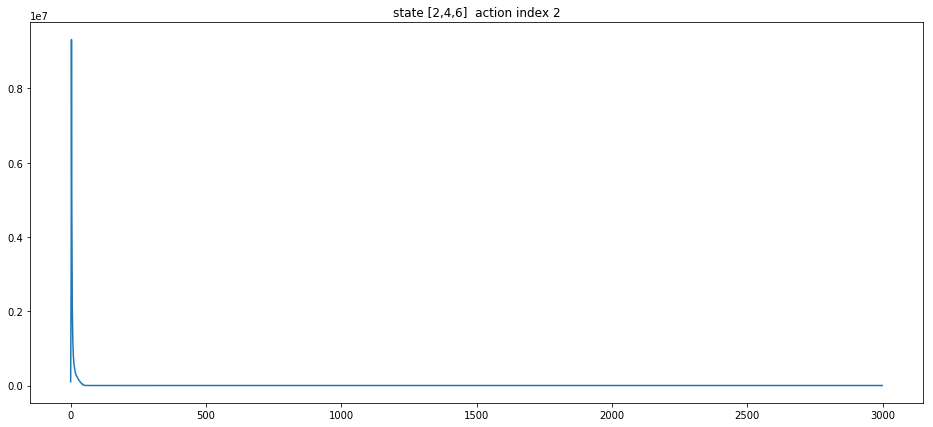

In [48]:
plt.figure(0, figsize=(16,7))
#plt.subplot(221)
plt.title('state [2,4,6]  action index 2')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.plot(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [56]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

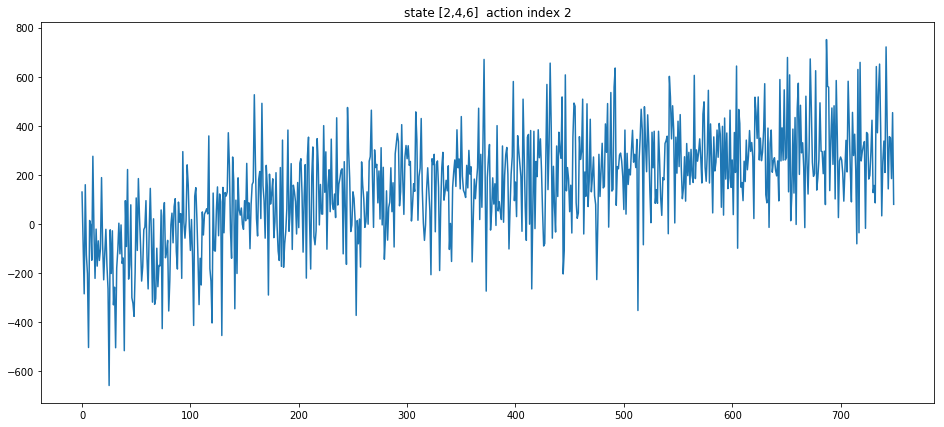

In [57]:
plt.figure(0, figsize=(16,7))
#plt.subplot(221)
plt.title('state [2,4,6]  action index 2')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

In [32]:
num_hits

101

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [33]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

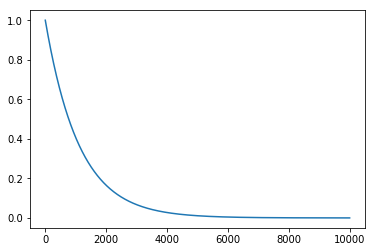

In [34]:
plt.plot(time, epsilon)
plt.show()

In [35]:
time = np.arange(0,3000)
epsilon = []
for i in range(0,3000):
    epsilon.append(0 + (1 - 0.00001) * np.exp(-0.0007*i))
    z = np.random.random()

In [36]:
time = np.arange(0,3000)
epsilon = []
epsilon_c = 1
for i in range(0,3000):
    epsilon.append(epsilon_c)
    epsilon_c = epsilon_c * 0.999

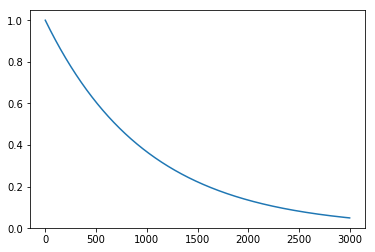

In [37]:
plt.plot(time, epsilon)
plt.show()

In [38]:
help(random.randrange)

Help on method randrange in module random:

randrange(start, stop=None, step=1, _int=<class 'int'>) method of random.Random instance
    Choose a random item from range(start, stop[, step]).
    
    This fixes the problem with randint() which includes the
    endpoint; in Python this is usually not what you want.

